# Extended Kalman Filter Implementation for Constant Turn Rate and Velocity (CTRV) Vehicle Model

![Extended Kalman Filter Step](Extended-Kalman-Filter-Step.png)

In [60]:
import numpy as np
%matplotlib inline
import csv
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import norm
from sympy import Symbol, symbols, latex, Matrix, sin, cos, sqrt, atan, Pow, Rational
from sympy import init_printing
init_printing(use_latex=True)

from IPython.core.display import display, HTML
display(HTML("""<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>"""))

# pretty formatting of np float arrays
float_formatter = lambda x: "%10.5f" % x
np.set_printoptions(formatter={'float_kind' : float_formatter})

numstates = 5 # States
estimated_states = ['$x$', '$y$', '$v$', '$\psi$', '$\dot \psi$']

def plot_covariance_matrix(fig, cov, states=estimated_states):
    states_num = len(states)
    im = plt.imshow(cov, interpolation="none", cmap=plt.get_cmap('binary'))
    ylocs, ylabels = plt.yticks()
    # set the locations of the yticks
    plt.yticks(np.arange(states_num))
    # set the locations and labels of the yticks
    plt.yticks(np.arange(states_num),states, fontsize=22)

    xlocs, xlabels = plt.xticks()
    # set the locations of the yticks
    plt.xticks(np.arange(states_num))
    # set the locations and labels of the yticks
    plt.xticks(np.arange(states_num),states, fontsize=22)

    plt.xlim([-0.5, (states_num-1)+0.5])
    plt.ylim([(states_num-1)+0.5, -0.5])

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    

def plot_state(x):
    x = np.array(x)
    U = x[2] * np.cos(x[3])
    V = x[2] * np.sin(x[3])

    fig = plt.figure()
    plt.quiver(x[0], x[1], U, V)
    plt.scatter(x[0], x[1], s=100)
    plt.title('Initial Location'); plt.show()

[Wikipedia](http://en.wikipedia.org/wiki/Extended_Kalman_filter) writes: In the extended Kalman filter, the state transition and observation models need not be linear functions of the state but may instead be differentiable functions.

$\boldsymbol{x}_{k} = g(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the Jacobian matrix) is computed.

At each time step, the Jacobian is evaluated with current predicted states. These matrices can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.

## State Vector - Constant Turn Rate and Velocity Vehicle Model (CTRV)

Situation covered: You have a velocity sensor, which measures the vehicle speed ($v$) in heading direction ($\psi$) and a yaw rate sensor ($\dot \psi$) which both have to fused with the position ($x$ & $y$) from a lidar and radar sensor.

Constant Turn Rate, Constant Velocity Model for a vehicle ![CTRV Model](CTRV-Model.png)

$$x_k= \left[ \matrix{ x \\ y \\ v \\ \psi \\ \dot\psi} \right] = \left[ \matrix{ \text{Position X} \\ \text{Position Y} \\ \text{Velocity} \\ \text{Heading} \\ \text{Yaw Rate}} \right]$$

We will fix the sensor sample rate of the sensor readings to $50~Hz$ for now.

In [25]:
dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz

### Developing the math behind dynamic model

All symbolic calculations are made with [Sympy](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb). Thanks!

In [3]:
vs, psis, dpsis, dts, xs, ys, phis, phids, rho = symbols('v \psi \dot\psi \Delta{t} x y \phi \dot\phi \\rho')
sigma_a_s, sigma_yaw_s = symbols('\sigma_a \sigma_{yaw}')

gs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(cos(psis)-cos(psis+dpsis*dts))],
             [vs],
             [psis+dpsis*dts],
             [dpsis]])

state = Matrix([xs,ys,psis,vs,dpsis])

## Dynamic Function $g$

This formulas calculate how the state is evolving from one to the next time step

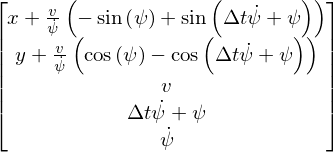

In [4]:
gs

### Calculate the Jacobian of the Dynamic function $g$ with respect to the state vector $x$

In [5]:
state

We will also set the inital state

[[   1.00000]
 [   2.00000]
 [   0.10000]
 [   0.30000]
 [   0.10000]]


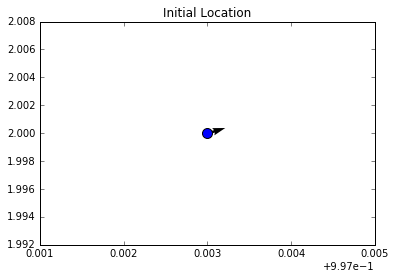

In [80]:
x = np.matrix([1., 2., 0.1, 0.3, 0.1]).T
print(x)
plot_state(x)

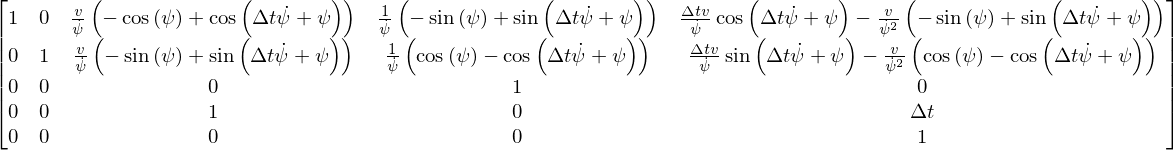

In [6]:
gs.jacobian(state)

It has to be computed on every filter step because it consists of state variables!

In [94]:
def update_F(x, dt):
    assert len(x) == 5, "State vector can only have 5 elements!"
    
    px, py, v, yaw, yawd = x
    Fj02 = v/yawd * (np.cos(dt*yawd + yaw) - np.cos(yaw))
    Fj03 = 1/yawd * (np.sin(dt*yawd + yaw) - np.sin(yaw))
    Fj04 = dt*v/yawd * np.cos(dt*yawd + yaw) - v/(yawd*yawd)*(np.sin(dt*yawd + yaw) - np.sin(yaw))
    Fj12 = v/yawd * (np.sin(dt*yawd + yaw) - np.sin(yaw))
    Fj13 = 1/yawd * (np.cos(yaw) - np.cos(dt*yawd + yaw))
    Fj14 = dt*v/yawd * np.sin(dt*yawd + yaw) - v/(yawd*yawd)*(np.cos(yaw) - np.cos(dt*yawd + yaw))
    F = np.matrix([[1.,  0.,  Fj02, Fj03, Fj04],
                   [0.,  1.,  Fj12, Fj13, Fj14],
                   [0.,  0.,  0.,    1.,    0.],
                   [0.,  0.,  1.,    0.,    dt],
                   [0.,  0.,  0.,    0.,    1.]])
    return F

F = update_F(x, dt)
print(F)
print("Shape: {}".format(F.shape))

[[   1.00000    0.00000   -0.00059    0.01910   -0.00001]
 [   0.00000    1.00000    0.00191    0.00593    0.00002]
 [   0.00000    0.00000    0.00000    1.00000    0.00000]
 [   0.00000    0.00000    1.00000    0.00000    0.02000]
 [   0.00000    0.00000    0.00000    0.00000    1.00000]]
Shape: (5, 5)


## Initial Uncertainty $P_0$

Initialized with $0$ means you are pretty sure where the vehicle starts

In [7]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P)
print("Shape: {}".format(P.shape))

[[1000.00000    0.00000    0.00000    0.00000    0.00000]
 [   0.00000 1000.00000    0.00000    0.00000    0.00000]
 [   0.00000    0.00000 1000.00000    0.00000    0.00000]
 [   0.00000    0.00000    0.00000 1000.00000    0.00000]
 [   0.00000    0.00000    0.00000    0.00000 1000.00000]]
Shape: (5, 5)


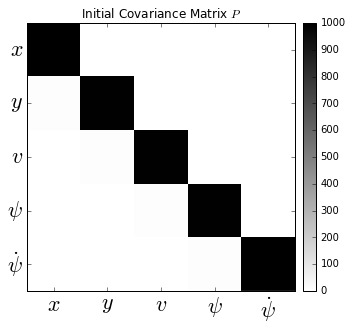

In [8]:
fig = plt.figure(figsize=(5, 5))
plt.title('Initial Covariance Matrix $P$')
plot_covariance_matrix(fig, P)
plt.tight_layout()

## Process Noise Covariance Matrix $Q$

"*The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.*" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

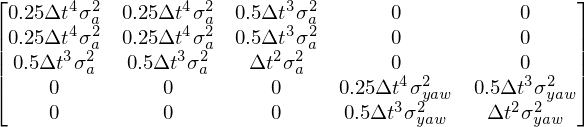

In [9]:
Gs = Matrix([[0.5*dts**2, 0],
             [0.5*dts**2, 0],
             [dts,        0],
             [0,          0.5*dts**2],
             [0,          dts]])
Gs

Qvs = Matrix([[sigma_a_s**2, 0],
              [0,            sigma_yaw_s**2]])

Qvs

Qs = Gs*Qvs*Gs.T
Qs

In [10]:
dt = 0.05
std_a = 4.0 # m/s^2
std_yawd = 0.5 # rad/s^2
pos_noise = 0.5*std_a*dt**2
yaw_noise = 0.5*std_yawd*dt**2

def update_Q(dt = 0.05):
    q1 = 0.25*(dt**4)*(std_a**2)
    q2 = 0.5*(dt**3)*(std_a**2)
    q3 = (dt**2)*(std_a**2)
    q4 = 0.25*(dt**4)*(std_yawd**2)
    q5 = 0.5*(dt**3)*(std_yawd**2)
    q6 = (dt**2)*(std_yawd**2)
    Q = np.matrix([[q1,  q1,  q2,  0,  0],
                   [q1,  q1,  q2,  0,  0],
                   [q2,  q2,  q3,  0,  0],
                   [0,   0,   0,   q4, q5],
                   [0,   0,   0,   q5, q6]])
    return Q

Q = update_Q(dt)
print(Q)
print("Shape: {}".format(Q.shape))

[[   0.00003    0.00003    0.00100    0.00000    0.00000]
 [   0.00003    0.00003    0.00100    0.00000    0.00000]
 [   0.00100    0.00100    0.04000    0.00000    0.00000]
 [   0.00000    0.00000    0.00000    0.00000    0.00002]
 [   0.00000    0.00000    0.00000    0.00002    0.00063]]
Shape: (5, 5)


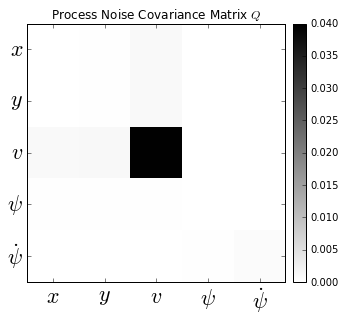

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.title('Process Noise Covariance Matrix $Q$')
plot_covariance_matrix(fig, Q)

## Real Measurements

In [12]:
OUTPUT_FILE_ALLSENSORS="../data/obj_pose-laser-radar-synthetic-input.txt"

def parse_csv(filename):
    measurements = []
    with open(OUTPUT_FILE_ALLSENSORS, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in reader:
            if row[0] == "L":
                sensor, px, py, timestamp, x_gt, y_gt, vx_gt, vy_gt, yaw_gt, yawrate_gt = row
                measurements.append([sensor, float(px), float(py), int(timestamp), float(x_gt), float(y_gt), float(vx_gt), float(vy_gt), float(yaw_gt), float(yawrate_gt)])
            elif row[0] == "R":            
                sensor, ro, theta, ro_dot, timestamp, x_gt, y_gt, vx_gt, vy_gt, yaw_gt, yawrate_gt = row
                measurements.append([sensor, float(ro), float(theta), float(ro_dot), int(timestamp), float(x_gt), float(y_gt), float(vx_gt), float(vy_gt), float(yaw_gt), float(yawrate_gt)])

    return measurements

measurements = np.array(parse_csv(OUTPUT_FILE_ALLSENSORS))
[print("{}\n".format(measurements[i])) for i in range(10)];

['L', 0.3122427, 0.5803398, 1477010443000000, 0.6, 0.6, 5.199937, 0.0, 0.0, 0.006911322]

['R', 1.014892, 0.5543292, 4.892807, 1477010443050000, 0.8599968, 0.6000449, 5.199747, 0.001796856, 0.0003455661, 0.01382155]

['L', 1.173848, 0.4810729, 1477010443100000, 1.119984, 0.6002246, 5.199429, 0.005389957, 0.001036644, 0.0207296]

['R', 1.047505, 0.3892401, 4.511325, 1477010443150000, 1.379955, 0.6006288, 5.198979, 0.01077814, 0.002073124, 0.02763437]

['L', 1.650626, 0.6246904, 1477010443200000, 1.639904, 0.6013473, 5.198392, 0.0179597, 0.003454842, 0.03453479]

['R', 1.6983, 0.2982801, 5.209986, 1477010443250000, 1.899823, 0.6024697, 5.197661, 0.02693234, 0.005181582, 0.04142974]

['L', 2.188824, 0.6487392, 1477010443300000, 2.159704, 0.6040855, 5.196776, 0.03769324, 0.007253069, 0.04831816]

['R', 2.044382, 0.2760018, 5.043867, 1477010443350000, 2.41954, 0.606284, 5.195728, 0.05023894, 0.009668977, 0.05519894]

['L', 2.655256, 0.6659798, 1477010443400000, 2.679323, 0.6091545, 5.194504

## Measurement Function $h$

The measurement function describes how the state vector maps into the sensor measurement.
Measurements from the lidar sensor can be directly transformed into the state vector and vice versa by applying linear kinematics equations, that's why the measurement function $h_{lidar}$ and hence the matrix $H_{lidar}$ are derived straight forward.

For radar measurements however this does not apply, transforming the state vector into the measurement vector involves non-linear functions like trigonometric functions like $tan$ or $arctan$. This means we have to linearize the equations by applying taylor series expansion and therefore calculating the jacobian of $H_{radar}$ with respect to the state vector.

In [13]:
hs_lidar = Matrix([[xs],  [ys]])
hs_lidar

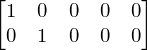

In [24]:
JHs_lidar=hs_lidar.jacobian(state)
JHs_lidar

In [ ]:
H_lidar = np.matrix([[1, 0, 0, 0],
                     [0, 1, 0, 0]])

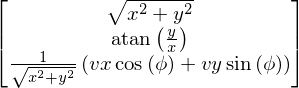

In [14]:
hs_radar = Matrix([[phis], [phids], [rho]])
hs_radar
vs, psis, dpsis, dts, xs, ys, phis, phids, rho = symbols('v \psi \dot\psi \Delta{t} x y \phi \dot\phi \\rho')
vxs = vs*cos(phis)
vys = vs*sin(phis)
hs_radar =  Matrix([[sqrt(xs**2 + ys**2)],
                    [atan(ys/xs)],
                    [(xs*vxs + ys*vys) / sqrt(Pow(xs,2) + Pow(ys,2))]])

hs_radar

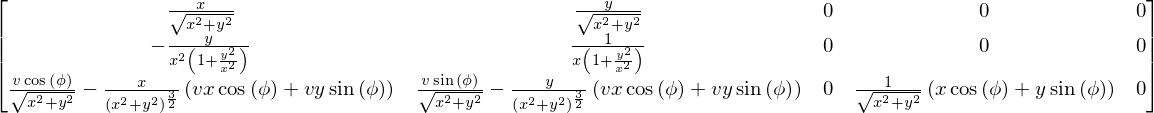

In [16]:
JHs_radar=hs_radar.jacobian(state)
JHs_radar

In [104]:
def update_H_radar(x):
    assert len(x) == 5, "State vector can only have 5 elements!"
    
    px, py, v, yaw, yawd = x
    px_2 = px*px
    py_2 = py*py
    norm = np.sqrt(px_2 + py_2)
    
    H11 = px / norm
    H12 = py / norm
    H21 = - py / ( (px**2) * (1 + py_2/px_2))
    H22 = 1. / (px * (1. + py_2/px_2))
    H31 = v * np.cos(yaw)/norm - px/(norm**3) * (v*px*np.cos(yaw) + v*py*np.sin(yaw))
    H32 = v * np.sin(yaw)/norm - py/(norm**3) * (v*px*np.cos(yaw) + v*py*np.sin(yaw))
    H34 = 1. / norm * (px * np.cos(yaw) + py * np.sin(yaw))
    H = np.matrix([[H11,   H12,    0,    0,      0],
                   [H21,   H22,    0,    0,      0],
                   [H31,   H32,    0,    H34,    0]])
    return H

H_radar = update_H_radar(x)
print(H_radar)
print("Shape: {}".format(H_radar.shape))

[[matrix([[   0.44721]]) matrix([[   0.89443]]) 0 0 0]
 [matrix([[  -0.40000]]) matrix([[   0.20000]]) 0 0 0]
 [matrix([[   0.02889]]) matrix([[  -0.01445]]) 0 matrix([[   0.69156]]) 0]]
Shape: (3, 5)


If no measurement is available, simply set the corresponding values in $J_h$ to zero.

## Measurement Noise Covariance $R$

"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [105]:
stdLidar       = 0.15   # standard deviation of lidar position measurement, applies for x and y [m]
stdRadarRange  = 0.3    # standard deviation of radius radar measurement [m]
stdRadarRo     = 0.03   # standard deviation of angle radar measurement [rad]
stdRadarRoDot  = 0.1    # standard deviation of angle rate radar measurement [rad/s]
R_lidar = np.matrix([[stdLidar,  0.0,      ],
                     [0.0,       stdLidar, ]])
print(R_lidar)
print("Shape: {}".format(R_lidar.shape))

R_radar =  np.matrix([[stdRadarRange, 0.0,         0],
                     [0.0,            stdRadarRo,  0],
                     [0.0,            0.0,         stdRadarRoDot]])
print(R_radar)
print("Shape: {}".format(R_radar.shape))

[[   0.15000    0.00000]
 [   0.00000    0.15000]]
Shape: (2, 2)
[[   0.30000    0.00000    0.00000]
 [   0.00000    0.03000    0.00000]
 [   0.00000    0.00000    0.10000]]
Shape: (3, 3)


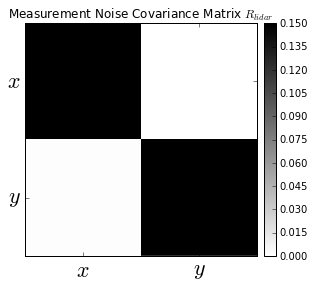

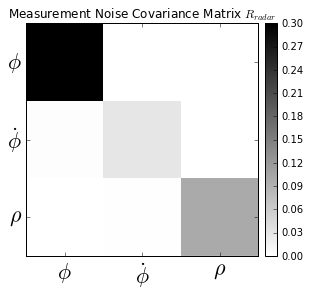

In [18]:
fig = plt.figure(figsize=(4.5, 4.5))
plt.title('Measurement Noise Covariance Matrix $R_{lidar}$')
plot_covariance_matrix(fig, R_lidar, ["$x$", "$y$"])

fig = plt.figure(figsize=(4.5, 4.5))
plt.title('Measurement Noise Covariance Matrix $R_{radar}$')
plot_covariance_matrix(fig, R_radar, ["$\phi$", "$\dot\phi$", "$\\rho$"])

### Put everything together as a measurement vector

In [20]:
# Lenth of the measurement
m = measurements.shape[0]
print(measurements.shape)
print(measurements[0])

(500,)
['L', 0.3122427, 0.5803398, 1477010443000000, 0.6, 0.6, 5.199937, 0.0, 0.0, 0.006911322]


In [21]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
dstate=[]


def savestates(x, Z, P, K):
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))

# Extended Kalman Filter

![Extended Kalman Filter Step](Extended-Kalman-Filter-Step.png)

$$x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \end{bmatrix} =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \\ x[3] \\ x[4]  \end{matrix}}_{\textrm{Python Nomenclature}}$$

In [106]:
for filterstep, measurement in enumerate(measurements):

    sensor_type = measurement[0]
    if sensor_type == "L":
        sensor_type, px, py, timestamp, x_gt, y_gt, vx_gt, vy_gt, yaw_gt, yawrate_gt = measurement
    elif sensor_type == "R":            
        sensor_type, ro, theta, ro_dot, timestamp, x_gt, y_gt, vx_gt, vy_gt, yaw_gt, yawrate_gt = measurement

        
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if np.abs(x[4]) < 0.00001: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[2])
        x[1] = x[1] + x[3]*dt * np.sin(x[2])
        x[2] = x[2]
        x[3] = x[3]
        x[4] = 0.00001 # avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/x[4]) * ( np.sin(x[4]*dt+x[2]) - np.sin(x[2]))
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2]))
        x[2] = x[2]
        x[3] = (x[3] + x[4]*dt) % (2.0*np.pi)
        x[4] = x[4]
        dstate.append(1)
    
    # Calculate the Jacobian of the Dynamic Matrix F (see above)
    F = update_F(x, dt)
    
    # Project the error covariance ahead
    P = F * P * F.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function ???
    hx = np.matrix([[x[0]],
                    [x[1]],
                    [x[3]],
                    [x[4]]])

    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])        
    
    S = JH * P * JH.T + R
    K = (P * JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - x                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))* P

    # Save states for Plotting
    savestates(x, Z, P, K)

ValueError: matrix must be 2-dimensional

## Lets take a look at the filter performance

In [ ]:
def plotP():
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),Px, label='$x$')
    plt.step(range(m),Py, label='$y$')
    plt.step(range(m),Pdx, label='$\psi$')
    plt.step(range(m),Pdy, label='$v$')
    plt.step(range(m),Pddx, label='$\dot \psi$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

### Uncertainties in $P$

In [ ]:
plotP()

In [ ]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Kalman Gains

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),Kx, label='$x$')
plt.step(range(len(measurements[0])),Ky, label='$y$')
plt.step(range(len(measurements[0])),Kdx, label='$\psi$')
plt.step(range(len(measurements[0])),Kdy, label='$v$')
plt.step(range(len(measurements[0])),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.1,0.1]);

## State Vector

In [ ]:
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(411)
    plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(412)
    plt.step(range(len(measurements[0])),x2, label='$\psi$')
    plt.step(range(len(measurements[0])),(course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
    plt.ylabel('Course')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(413)
    plt.step(range(len(measurements[0])),x3, label='$v$')
    plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(414)
    plt.step(range(len(measurements[0])),x4, label='$\dot \psi$')
    plt.step(range(len(measurements[0])),yawrate/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)')
    plt.ylabel('Yaw Rate')
    plt.ylim([-0.6, 0.6])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CTRV-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

In [ ]:
plotx()

## Position x/y

In [ ]:
#%pylab --no-import-all

In [ ]:
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    # Start/Goal
    plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
    plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()

    #plt.savefig('Extended-Kalman-Filter-CTRV-Position.png', dpi=72, transparent=True, bbox_inches='tight')

In [ ]:
plotxy()

### Detailed View

In [ ]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')

In [ ]:
plotxydetails()

# Conclusion

As you can see, complicated analytic calculation of the Jacobian Matrices, but it works pretty well.

## Write Google Earth KML

### Convert back from Meters to Lat/Lon (WGS84)

In [ ]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))

### Create Data for KML Path

Coordinates and timestamps to be used to locate the car model in time and space
The value can be expressed as yyyy-mm-ddThh:mm:sszzzzzz, where T is the separator between the date and the time, and the time zone is either Z (for UTC) or zzzzzz, which represents ±hh:mm in relation to UTC.

In [ ]:
import datetime
car={}
car['when']=[]
car['coord']=[]
car['gps']=[]
for i in range(len(millis)):
    d=datetime.datetime.fromtimestamp(millis[i]/1000.0)
    car["when"].append(d.strftime("%Y-%m-%dT%H:%M:%SZ"))
    car["coord"].append((lonekf[i], latekf[i], 0))
    car["gps"].append((longitude[i], latitude[i], 0))

In [ ]:
from simplekml import Kml, Model, AltitudeMode, Orientation, Scale, Style, Color

In [ ]:
# The model path and scale variables
car_dae = r'https://raw.githubusercontent.com/balzer82/Kalman/master/car-model.dae'
car_scale = 1.0

# Create the KML document
kml = Kml(name=d.strftime("%Y-%m-%d %H:%M"), open=1)

# Create the model
model_car = Model(altitudemode=AltitudeMode.clamptoground,
                            orientation=Orientation(heading=75.0),
                            scale=Scale(x=car_scale, y=car_scale, z=car_scale))

# Create the track
trk = kml.newgxtrack(name="EKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from Extended Kalman Filter with CTRV Model")

# Attach the model to the track
trk.model = model_car
trk.model.link.href = car_dae

# Add all the information to the track
trk.newwhen(car["when"])
trk.newgxcoord(car["coord"])

# Style of the Track
trk.iconstyle.icon.href = ""
trk.labelstyle.scale = 1
trk.linestyle.width = 4
trk.linestyle.color = '7fff0000'

# Add GPS measurement marker
fol = kml.newfolder(name="GPS Measurements")
sharedstyle = Style()
sharedstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'

for m in range(len(latitude)):
    if GPS[m]:
        pnt = fol.newpoint(coords = [(longitude[m],latitude[m])])
        pnt.style = sharedstyle

# Saving
#kml.save("Extended-Kalman-Filter-CTRV.kml")
kml.savekmz("Extended-Kalman-Filter-CTRV.kmz")

In [23]:
print('Exported KMZ File for Google Earth')

Exported KMZ File for Google Earth
